In [2]:
url = "https://www.agof.de/service-downloads/downloadcenter/download-daily-digital-facts/"

In [3]:
import requests

In [4]:
rv = requests.get(url)

In [5]:
body = rv.content.decode("utf-8")

In [6]:
type(body)

str

In [8]:
#body

In [14]:
from bs4 import BeautifulSoup

In [15]:
soup = BeautifulSoup(body, "html.parser")

In [20]:
tables_list = soup.find_all("tr")

In [24]:
tables_list[3]

<tr><td><a href="https://www.agof.de/?wpfb_dl=8558" target="_blank">ddf_Oktober_2021_Angebote_Ranking_Internet</a></td><td>pdf</td><td>279.6 KB</td></tr>

In [25]:
first_tag = tables_list[1]

In [26]:
first_tag.text

'ddf_Oktober_2021_Angebote_Ranking_Digitalxlsx49.0 KB'

In [27]:
links = [item for item in tables_list if "Angebote Ranking" in item.text]

In [28]:

links_list = [item for item in links if "xlsx" in item.text]

In [32]:
str(links_list[0])

'<tr><td><a href="https://www.agof.de/?wpfb_dl=8254" target="_blank">Ddf März 2021 Angebote Ranking Digital</a></td><td>xlsx</td><td>50.5 KB</td></tr>'

In [33]:
import re
re.findall("href=[\"\'](.+?)[\"\']", str(links_list[0]))

['https://www.agof.de/?wpfb_dl=8254']

In [34]:

xls = []
for i in links_list:
    xls.append(re.findall("href=[\"\'](.+?)[\"\']", str(i))[0])


In [35]:
xls

['https://www.agof.de/?wpfb_dl=8254',
 'https://www.agof.de/?wpfb_dl=8249',
 'https://www.agof.de/?wpfb_dl=8248',
 'https://www.agof.de/?wpfb_dl=8222',
 'https://www.agof.de/?wpfb_dl=8220',
 'https://www.agof.de/?wpfb_dl=8231',
 'https://www.agof.de/?wpfb_dl=8186',
 'https://www.agof.de/?wpfb_dl=8191',
 'https://www.agof.de/?wpfb_dl=8188',
 'https://www.agof.de/?wpfb_dl=8150',
 'https://www.agof.de/?wpfb_dl=8159',
 'https://www.agof.de/?wpfb_dl=8164',
 'https://www.agof.de/?wpfb_dl=8122',
 'https://www.agof.de/?wpfb_dl=8131',
 'https://www.agof.de/?wpfb_dl=8124',
 'https://www.agof.de/?wpfb_dl=8088',
 'https://www.agof.de/?wpfb_dl=8096',
 'https://www.agof.de/?wpfb_dl=8093',
 'https://www.agof.de/?wpfb_dl=8053',
 'https://www.agof.de/?wpfb_dl=8054',
 'https://www.agof.de/?wpfb_dl=8057',
 'https://www.agof.de/?wpfb_dl=8021',
 'https://www.agof.de/?wpfb_dl=8014',
 'https://www.agof.de/?wpfb_dl=8020',
 'https://www.agof.de/?wpfb_dl=7984',
 'https://www.agof.de/?wpfb_dl=7978',
 'https://ww

In [19]:
xls[0]

'https://www.agof.de/?wpfb_dl=8254'

In [36]:
len(xls)

135

In [38]:
# process the first item, then create a loop to process a couple more
rv = requests.get(xls[0])

In [39]:
open("/tmp/test.xlsx", "wb").write(rv.content)

50537

In [41]:
import pandas as pd
#df2 = pd.read_excel("/tmp/test.xlsx", skiprows = 8) #- also possible but we loose meta data

In [42]:
# read data without skipping rows and find out the start
df = pd.read_excel("/tmp/test.xlsx", header=None)

In [43]:
df.shape

(422, 7)

In [45]:
df.head(20)

,0,1,2,3,4,5,6
0,Analyse,daily digital facts 08.04.2021 / Rangreihe,NaN,NaN,NaN,NaN,NaN
1,Grundgesamtheit,16 Jahre und älter,NaN,NaN,NaN,NaN,NaN
2,Zeitraum,Letzter Monat (März 2021),NaN,NaN,NaN,NaN,NaN
3,Vorfilter,Nutzer mobiler und/oder stationärer Angebote (...,NaN,NaN,NaN,NaN,NaN
4,NaN,"(279.781 ungew. Fälle, 280.507 gew. Fälle, 61,...",NaN,NaN,NaN,NaN,NaN
5,Zielgruppe,Gesamt,NaN,NaN,NaN,NaN,NaN
6,NaN,"(279.781 ungew. Fälle, 280.507 gew. Fälle, 61,...",NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Medientyp,Ungew. Fälle\nauf Basis\nGesamt 16+,Fälle (ungew.)\nauf Basis\nZG/Vorfilter,Unique User\n%,Unique User\nMio,Kontakte\nMio
9,Basis,NaN,0,279781,100,61.17,NaN


In [46]:
assert df.iloc[0, 0] == "Analyse"
analyse = df.iloc[0, 1]
assert df.iloc[1, 0] == "Grundgesamtheit"
grundgesamtheit = df.iloc[1, 1]
assert df.iloc[2, 0] == "Zeitraum"
zeitraum = df.iloc[2, 1]
assert df.iloc[3, 0] == "Vorfilter"
vorfilter = df.iloc[3, 1]
vorfilter_fallzahl = df.iloc[4, 1]
assert df.iloc[5, 0] == "Zielgruppe"
zielgruppe = df.iloc[5, 1]
zielgruppe_fallzahl = df.iloc[6, 1]

In [47]:
ln = 7
while df.iloc[ln, 0] != "Basis":
    ln += 1
    if ln > 1000:
        raise  RuntimeError("failed to identify start of data")

In [48]:
ln

9

In [49]:
dframe = df.iloc[ln:].copy()

In [50]:
dframe.head()

,0,1,2,3,4,5,6
9,Basis,NaN,0,279781,100,61.17,NaN
10,ebay Kleinanzeigen,Digitales Gesamtangebot,0,204530,65.6,40.14,13836.26
11,t-online,Digitales Gesamtangebot,0,166282,51.2,31.34,1911.29
12,FOCUS Online,Digitales Gesamtangebot,0,142662,44.4,27.17,526.58
13,DER SPIEGEL SPM,Digitales Gesamtangebot,0,143586,43.9,26.85,747.81


In [51]:
dframe = df.iloc[ln:].copy()
cols = list(df.iloc[ln-1])
cols[0] = "Titel"
dframe.columns = ["" if pd.isnull(c)
             else c.replace("\n", " ").replace(".", "") for c in cols]
if "" in dframe.columns:
    dframe.drop([""], axis=1, inplace=True)
dframe["Analyse"] = analyse
dframe["Grundgesamtheit"] = grundgesamtheit
dframe["Zeitraum"] = zeitraum
dframe["Vorfilter"] = vorfilter
dframe["Zielgruppe"] = zielgruppe

In [52]:
dframe.head()

,Titel,Medientyp,Ungew Fälle auf Basis Gesamt 16+,Fälle (ungew) auf Basis ZG/Vorfilter,Unique User %,Unique User Mio,Kontakte Mio,Analyse,Grundgesamtheit,Zeitraum,Vorfilter,Zielgruppe
9,Basis,NaN,0,279781,100,61.17,NaN,daily digital facts 08.04.2021 / Rangreihe,16 Jahre und älter,Letzter Monat (März 2021),Nutzer mobiler und/oder stationärer Angebote (...,Gesamt
10,ebay Kleinanzeigen,Digitales Gesamtangebot,0,204530,65.6,40.14,13836.26,daily digital facts 08.04.2021 / Rangreihe,16 Jahre und älter,Letzter Monat (März 2021),Nutzer mobiler und/oder stationärer Angebote (...,Gesamt
11,t-online,Digitales Gesamtangebot,0,166282,51.2,31.34,1911.29,daily digital facts 08.04.2021 / Rangreihe,16 Jahre und älter,Letzter Monat (März 2021),Nutzer mobiler und/oder stationärer Angebote (...,Gesamt
12,FOCUS Online,Digitales Gesamtangebot,0,142662,44.4,27.17,526.58,daily digital facts 08.04.2021 / Rangreihe,16 Jahre und älter,Letzter Monat (März 2021),Nutzer mobiler und/oder stationärer Angebote (...,Gesamt
13,DER SPIEGEL SPM,Digitales Gesamtangebot,0,143586,43.9,26.85,747.81,daily digital facts 08.04.2021 / Rangreihe,16 Jahre und älter,Letzter Monat (März 2021),Nutzer mobiler und/oder stationärer Angebote (...,Gesamt


In [53]:
dframe.Zeitraum.value_counts()

Letzter Monat (März 2021)     413
Name: Zeitraum, dtype: int64

In [55]:
def process(df):
    assert df.iloc[0, 0] == "Analyse"
    analyse = df.iloc[0, 1]
    assert df.iloc[1, 0] == "Grundgesamtheit"
    grundgesamtheit = df.iloc[1, 1]
    assert df.iloc[2, 0] == "Zeitraum"
    zeitraum = df.iloc[2, 1]
    assert df.iloc[3, 0] == "Vorfilter"
    vorfilter = df.iloc[3, 1]
    vorfilter_fallzahl = df.iloc[4, 1]
    assert df.iloc[5, 0] == "Zielgruppe"
    zielgruppe = df.iloc[5, 1]
    zielgruppe_fallzahl = df.iloc[6, 1]
    ln = 7
    while df.iloc[ln, 0] != "Basis":
        ln += 1
        if ln > 1000:
            raise  RuntimeError("failed to identify start of data")
    d = df.iloc[ln:].copy()
    cols = list(df.iloc[ln-1])
    cols[0] = "Titel"
    d.columns = ["" if pd.isnull(c)
                 else c.replace("\n", " ").replace(".", "") for c in cols]
    if "" in d.columns:
        d.drop([""], axis=1, inplace=True)
    d["Analyse"] = analyse
    d["Grundgesamtheit"] = grundgesamtheit
    d["Zeitraum"] = zeitraum
    d["Vorfilter"] = vorfilter
    d["Zielgruppe"] = zielgruppe
    return(d)
    

In [57]:
fin_df = list()
fin_df.append(dframe)
for i in range(1,30):
    rv = requests.get(xls[i])
    open("/tmp/test"+str(i)+".xlsx", "wb").write(rv.content)
    df = pd.read_excel("/tmp/test"+str(i)+".xlsx", header=None)
    df_processed = process(df)
    fin_df.append(df_processed)
    
fin_df = pd.concat(fin_df)

In [58]:
fin_df.shape

(11258, 12)

In [59]:
fin_df.Zeitraum.value_counts()

Letzter Monat (Juni 2020)          1171
Letzter Monat (Juli 2020)          1162
Letzter Monat (August 2020)        1160
Letzter Monat (September 2020)     1155
Letzter Monat (Dezember 2020)      1131
Letzter Monat (November 2020)      1130
Letzter Monat (Oktober 2020)       1125
Letzter Monat (Januar 2021)        1078
Letzter Monat (März 2021)          1076
Letzter Monat (Februar 2021)       1070
Name: Zeitraum, dtype: int64

In [60]:
import datetime
MONAT = {
    "Januar": "01",
    "Februar": "02",
    "März": "03",
    "April": "04",
    "Mai": "05",
    "Juni": "06",
    "Juli": "07",
    "August": "08",
    "September": "09",
    "Oktober": "10",
    "November": "11",
    "Dezember": "12"
}
monat = fin_df.Zeitraum.apply(lambda s: s.replace("Letzter Monat (", "").replace(")", "").split())

In [61]:
type(monat)

pandas.core.series.Series

In [62]:
monat.head()

9     [März, 2021]
10    [März, 2021]
11    [März, 2021]
12    [März, 2021]
13    [März, 2021]
Name: Zeitraum, dtype: object

In [63]:
fin_df["Monat"] = [datetime.datetime.strptime("01." + MONAT[m[0]] + "." + m[1], "%d.%m.%Y") for m in monat]

In [64]:
fin_df["val"] = fin_df["Kontakte Mio"].apply(pd.to_numeric, errors='coerce')
fin_df['Date'] = fin_df.Monat.apply(lambda x: x.date().isoformat())

In [66]:
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


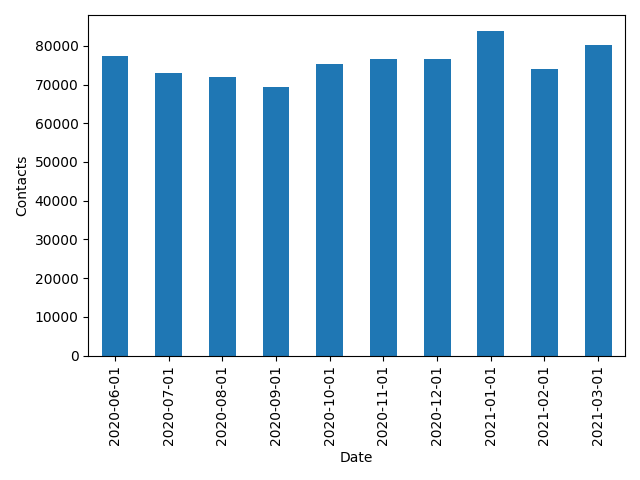

In [67]:
import numpy as np
fin_df = fin_df.replace(np.nan,0)
g = fin_df.groupby(["Date"]).val.sum()
g.plot.bar()
plt.ylabel("Contacts")
plt.tight_layout()

In [68]:
fin_df.columns

Index(['Titel', 'Medientyp', 'Ungew Fälle auf Basis Gesamt 16+',
       'Fälle (ungew) auf Basis ZG/Vorfilter', 'Unique User %',
       'Unique User Mio', 'Kontakte Mio', 'Analyse', 'Grundgesamtheit',
       'Zeitraum', 'Vorfilter', 'Zielgruppe', 'Monat', 'val', 'Date'],
      dtype='object')

In [69]:
fin_df.Medientyp.unique()

array([0, 'Digitales Gesamtangebot', 'Website Angebot',
       'Mobiles Gesamtangebot'], dtype=object)

<IPython.core.display.Javascript object>


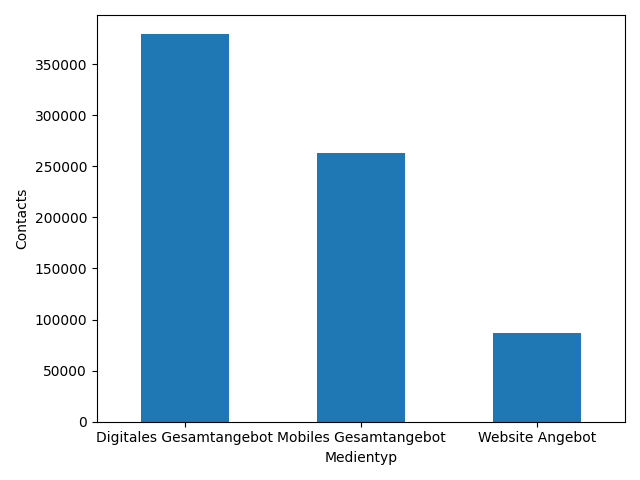

In [70]:
%matplotlib notebook
df_new = fin_df[fin_df.Medientyp != 0]
g1 = df_new.groupby(["Medientyp"]).val.sum()
g1.plot.bar()
plt.ylabel("Contacts")
plt.xticks(rotation='horizontal')
plt.tight_layout()

In [71]:
list(g1.index)

['Digitales Gesamtangebot', 'Mobiles Gesamtangebot', 'Website Angebot']

<IPython.core.display.Javascript object>


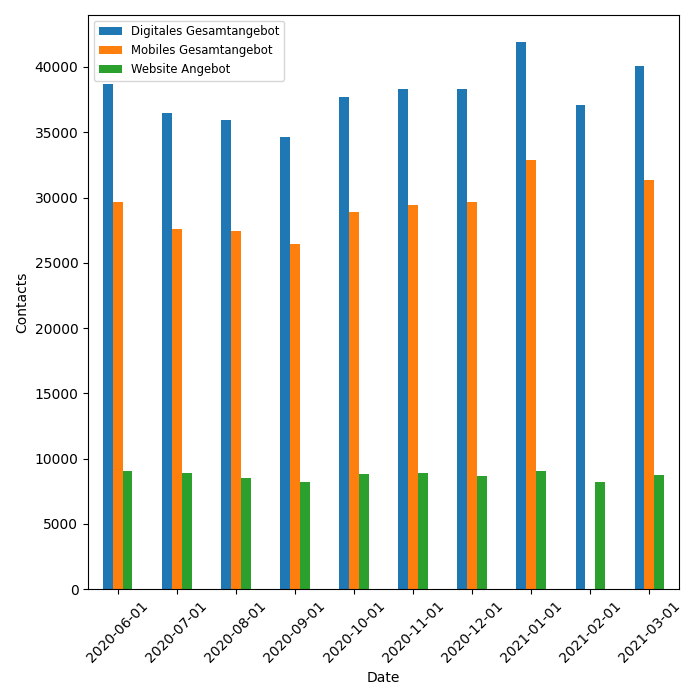

In [72]:
%matplotlib notebook

df_new = fin_df[fin_df.Medientyp != 0]
# Monthly contacts for each media group
g1 = df_new.groupby(["Date","Medientyp"]).val.sum().unstack()
# contact of different media group per month
# g1 = df_new.groupby(["Date","Medientyp"]).val.sum().unstack(0)
plt.rcParams["figure.figsize"] = [7,7]
g1.plot.bar(rot=45)

plt.ylabel("Contacts")
plt.legend(fontsize='small')
plt.tight_layout()